# Image Segmentation Project
### A deep learning and computer vision project to segment and locate the image of humans with various backgrounds.
- used U-net architechture with efficientnet-b0 as encoder for CNN to train the model
- used albumentations for randomly augment the image with correspondin the mask
- used a combination of Binary Cross Entropy loss and Dice loss for computing loss
- used OpenCV for reading and pre-processing images
- used cuda runtime for faster training

## Set up colab gpu runtime environment

In [38]:
!pip install segmentation-models-pytorch 
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-y4g_q3e9
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-y4g_q3e9
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


## Some Common Imports

In [40]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [41]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

## Setup Configurations

In [42]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/CONTENT/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [43]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [44]:
row = df.iloc[21]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

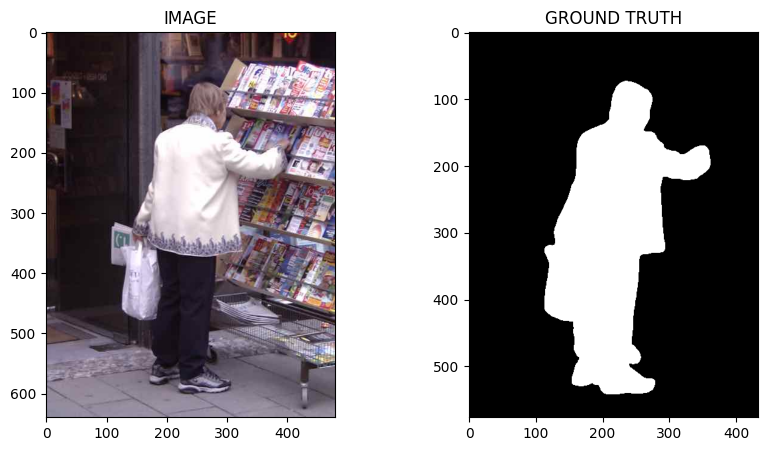

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [46]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

## Augmentation Functions

In [47]:
import albumentations as A

In [48]:
def get_train_augs() :
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE, always_apply=True),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_valid_augs() :
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE, always_apply=True)
  ], is_check_shapes=False)


## Create Custom Dataset 

In [49]:
from torch.utils.data import Dataset

In [50]:
class SegmentationDataset(Dataset):
  
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask, is_check_shapes=False)
      image = data['image']
      mask = data['mask']

    #(h, w, c) -> (c, h, w)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.Tensor(mask)/255.0

    return image, mask

In [51]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [52]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


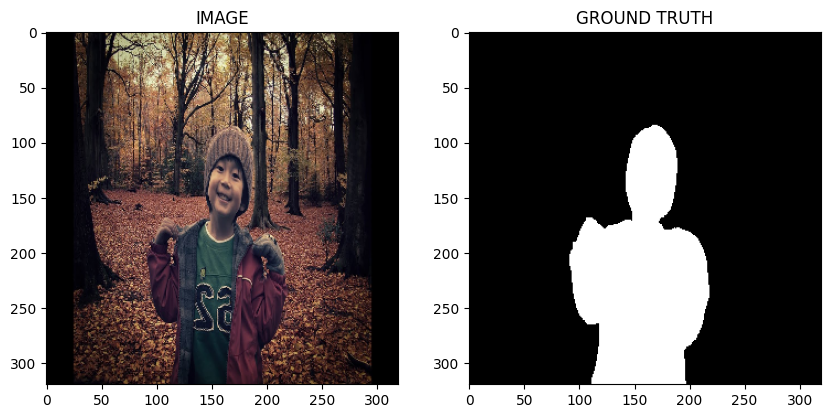

In [53]:
idx = 21

image, mask = trainset[idx]

helper.show_image(image, mask)

## Load dataset into batches

In [54]:
from torch.utils.data import DataLoader 

In [55]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [56]:
print(f"total no. of batches in trainloader: {len(trainloader)}")
print(f"total no. of batches in validloader: {len(validloader)}")

total no. of batches in trainloader: 15
total no. of batches in validloader: 4


In [57]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


## Create Segmentation Model

In [58]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [59]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3, 
        classes = 1,
        activation = None
    )

  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    return logits

In [60]:
model = SegmentationModel() 
model.to(DEVICE) ;

## Create Train and Validation Function 

In [61]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)

In [62]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():  
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      
      total_loss += loss.item()

  return total_loss/len(data_loader)

## Train Model

In [63]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [64]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss :
    best_valid_loss = valid_loss 
    torch.save(model.state_dict(), 'best_model.pt')
    print('SAVED-MODEL')

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss: {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


SAVED-MODEL
Epoch : 1 Train_loss : 0.7390714883804321 Valid_loss: 2.7279810905456543


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


SAVED-MODEL
Epoch : 2 Train_loss : 0.3850753019253413 Valid_loss: 0.3909093290567398


100%|██████████| 4/4 [00:01<00:00,  3.06it/s]


SAVED-MODEL
Epoch : 3 Train_loss : 0.327470072110494 Valid_loss: 0.298089150339365


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


SAVED-MODEL
Epoch : 4 Train_loss : 0.25472313662370044 Valid_loss: 0.24927282333374023


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


Epoch : 5 Train_loss : 0.22257966895898182 Valid_loss: 0.357192687690258


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Epoch : 6 Train_loss : 0.20986926356951396 Valid_loss: 0.31903982535004616


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


Epoch : 7 Train_loss : 0.2639185200134913 Valid_loss: 0.26013925299048424


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Epoch : 8 Train_loss : 0.18366601467132568 Valid_loss: 0.29531270265579224


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


Epoch : 9 Train_loss : 0.19756600608428318 Valid_loss: 0.28077251464128494


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


SAVED-MODEL
Epoch : 10 Train_loss : 0.1899966523051262 Valid_loss: 0.24221380054950714


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


SAVED-MODEL
Epoch : 11 Train_loss : 0.15562853515148162 Valid_loss: 0.20057770982384682


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


Epoch : 12 Train_loss : 0.17298941959937414 Valid_loss: 0.2555980682373047


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


SAVED-MODEL
Epoch : 13 Train_loss : 0.16849583486715952 Valid_loss: 0.18307417258620262


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


Epoch : 14 Train_loss : 0.15947163651386898 Valid_loss: 0.24114399030804634


100%|██████████| 4/4 [00:00<00:00,  5.27it/s]


Epoch : 15 Train_loss : 0.17331162889798482 Valid_loss: 0.20308499410748482


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


Epoch : 16 Train_loss : 0.13504431794087093 Valid_loss: 0.25736480206251144


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


Epoch : 17 Train_loss : 0.12872888445854186 Valid_loss: 0.22535688430070877


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


SAVED-MODEL
Epoch : 18 Train_loss : 0.12460343738396963 Valid_loss: 0.1789550632238388


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


Epoch : 19 Train_loss : 0.12511100669701894 Valid_loss: 0.25328123569488525


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


SAVED-MODEL
Epoch : 20 Train_loss : 0.1156367893020312 Valid_loss: 0.17670723795890808


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


Epoch : 21 Train_loss : 0.11434232195218404 Valid_loss: 0.22989529743790627


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Epoch : 22 Train_loss : 0.11519224296013514 Valid_loss: 0.2152748852968216


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


SAVED-MODEL
Epoch : 23 Train_loss : 0.10608560492595037 Valid_loss: 0.17654020339250565


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


SAVED-MODEL
Epoch : 24 Train_loss : 0.10322475532690684 Valid_loss: 0.17127995193004608


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]

Epoch : 25 Train_loss : 0.1190071110924085 Valid_loss: 0.19215727224946022


## Inference

In [68]:
model.load_state_dict(torch.load('/content/best_model.pt'))

idx = 3
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))  #(c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0


idx = 41
image2, mask2 = validset[idx]

logits_mask2 = model(image2.to(DEVICE).unsqueeze(0))  
pred_mask2 = torch.sigmoid(logits_mask2)
pred_mask2 = (pred_mask2>0.5)*1.0

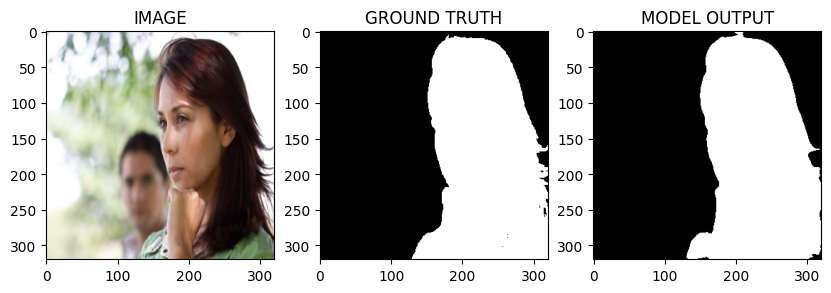

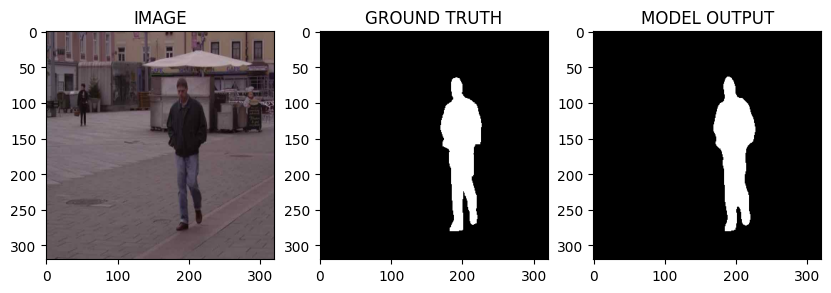

In [69]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))
helper.show_image(image2, mask2, pred_mask2.detach().cpu().squeeze(0))